In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import traceback
import logging
import multiprocessing
import tabusearch_classes as ts_classes
import archive_module as am


In [105]:
elements= 10
u0= 1.5
max_twist = np.pi/8
min_twist = np.pi/150
TSR_max = 10
TSR_min = 4
Number_Blades = 3
starting_radius = 0.095
tip_constraint = 1.0
swept_radius = 0.98
aerofoils = ['naca4412', 'naca4415', 'naca23012']
aerofoil_name = aerofoils[2]
blade_length = swept_radius * (1 - starting_radius - (1 - tip_constraint))
relaxation_factor = 1.0 # Convergence speed for BEM method 
alpha_max = 21 # maximum allowed angle of attack

# Import XFOIL Interpolator MAPS

In [106]:
cl_interpolators_path = 'CL_interpolators.pkl'
cd_interpolators_path = 'CD_interpolators.pkl'

# Load CL_interpolators
try:
    with open(cl_interpolators_path, 'rb') as f:
        CL_interpolators = pickle.load(f)
    print('Successfully loaded CL_interpolators')
except Exception as e:
    print(f'Failed to load CL_interpolators: {e}')
 
# Load CD_interpolators
try:
    with open(cd_interpolators_path, 'rb') as f:
        CD_interpolators = pickle.load(f)
    print('Successfully loaded CD_interpolators')
except Exception as e:
    print(f'Failed to load CD_interpolators: {e}')

def check_bounds(Re, alpha, aerofoil):
    # Check if the values are within bounds
    if Re < CL_interpolators[aerofoil].grid[0][0]:
        #print('Re smaller than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][0]
        
    elif Re > CL_interpolators[aerofoil].grid[0][-1]:
        #print('Re higher than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][-1]
        
    if alpha < CD_interpolators[aerofoil].grid[1][0]:
        #print('Alpha smaller than grid', alpha )
        alpha = CD_interpolators[aerofoil].grid[1][0]
        
    elif alpha > CD_interpolators[aerofoil].grid[1][-1]:
        #print('Alpha higher than grid', alpha)
        alpha = CD_interpolators[aerofoil].grid[1][-1]
    return (Re, alpha)

def check_bounds_debug(Re, alpha, aerofoil):
    # Check if the values are within bounds
    if Re < CL_interpolators[aerofoil].grid[0][0]:
        print('Re smaller than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][0]
        
    elif Re > CL_interpolators[aerofoil].grid[0][-1]:
        print('Re higher than grid', Re)
        Re = CL_interpolators[aerofoil].grid[0][-1]
        
    if alpha < CD_interpolators[aerofoil].grid[1][0]:
        print('Alpha smaller than grid', alpha )
        alpha = CD_interpolators[aerofoil].grid[1][0]
        
    elif alpha > CD_interpolators[aerofoil].grid[1][-1]:
        print('Alpha higher than grid', alpha)
        alpha = CD_interpolators[aerofoil].grid[1][-1]
        
    return (Re, alpha)


Successfully loaded CL_interpolators
Successfully loaded CD_interpolators


# BEM Method and Power Coefficient

### Taper function

In [107]:
def taper_function(r, c0, a1, a2, a3, l_blade, rhub=starting_radius):
    """
    Quadratic polynomial taper function.
    
    Parameters:
    r (array-like): Radial positions.
    a0 (float): Root chord length
    a1 (float): Coefficient for r^1 
    a2 (float): Coefficient for r^2 

    Returns:
    array-like: Taper values at each radial position.
    """
    return c0 * (1 - ((1 - a1) * (r-rhub) / l_blade + (1 - a2) * ((r-rhub)/l_blade)**2 + (1 - a3) * ((r-rhub)/l_blade)**3))  

## BEM debugging

In [108]:
def BEM_debug(x, aerofoil, n_blades=3, u0=u0, tip_constraint=tip_constraint, rhub=starting_radius, r_total=swept_radius, n=elements, relax=relaxation_factor, alpha_max=alpha_max, chord=None, theta=None):
    """ BEM method for the entire blade 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, tsr, a1, a2, a3, alpha = x
    # Constants
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    if chord is None:
        c = c0 * (1 - ((1 - a1) * (r-rhub) / l_blade + (1 - a2) * ((r-rhub)/l_blade)**2 + (1 - a3) * ((r-rhub)/l_blade)**3))  
    else:
        c = chord # use manual input
    volume = sum(dr * 0.045*c**2) # volume of the blade
    area = sum(dr*c)
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    twirl = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        print('------------------------------------------')
        print(f'Element {i}')
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 100: 
                print('Not converged')
                return None
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            twirl[i] = np.degrees(phi) - alpha # twirl
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha, aerofoil) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = CL_interpolators[aerofoil](checked_values) # lift coefficeint
            Cd = CD_interpolators[aerofoil](checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    # print(f'Number of iterations: {counter}')
                    # print(f'Angle of attack: {alpha}')
                    # print(f'Reynolds: {Re}')
                    # print(f'CL: {Cl}')
                    # print(f'CD: {Cd}')
                    # print(f'a: {a[i]}')
                    # print(f'Chord length {c[i]}')
                    # print(f'Twirl {twirl[i]}')
                    if alpha > alpha_max:
                        warnings.warn(f'Angle of attack too high at element {i} at wind speed {u0}: alpha = {alpha}', RuntimeWarning)
                    if a[i] < 0:
                        warnings.warn(f'Negative induction factor at element {i}: a = {a[i]}', RuntimeWarning)
                        a[i] = 0  # Set a to zero to maintain physical bounds
                    break
            counter += 1
        if twirl[i] < 0:
            return None
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*dr
    for i in range(n):
        print(f'dQ{i}: {dQ[i]}')
    # if np.any(dQ < 0):
    #     print('Negative dQ values')
    #     return None
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, omega, volume, area, twirl)

### BEM manual twirl

In [109]:
def BEM_manual_twirl(x, aerofoil, theta, n_blades=3, u0=u0, tip_constraint=tip_constraint, rhub=starting_radius, r_total=swept_radius, n=elements, relax=relaxation_factor, alpha_max=alpha_max, chord=None):
    """ BEM method for the entire blade. The Twist is to be plugged in beforehand 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, tsr, a1, a2, a3 = x[:5]
    alpha = np.array(x[5:5+n])
    # Constants
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    if chord is None:
        c = c0 * (1 - ((1 - a1) * (r-rhub) / l_blade + (1 - a2) * ((r-rhub)/l_blade)**2 + (1 - a3) * ((r-rhub)/l_blade)**3))  
    else:
        c = chord # use manual input
    twirl = theta # use manual input
    # print('c', c)
    # print('twirl', twirl)
    volume = sum(dr * 0.045*c**2) # volume of the blade
    area = sum(dr*c)
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        # print('------------------------------------------')
        # print(f'Element {i}')
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 100: 
                print('Not converged')
                return None
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            alpha = np.degrees(phi) - twirl[i] # local angle of attack in degrees
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha, aerofoil) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = CL_interpolators[aerofoil](checked_values) # lift coefficeint
            Cd = CD_interpolators[aerofoil](checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    # print(f'Number of iterations: {counter}')
                    # print(f'Angle of attack: {alpha}')
                    # print(f'Reynolds: {Re}')
                    # print(f'CL: {Cl}')
                    # print(f'CD: {Cd}')
                    # print(f'a: {a[i]}')
                    # print(f'Chord length {c[i]}')
                    # print(f'Twirl {twirl[i]}')
                    # if alpha > alpha_max:
                    #     warnings.warn(f'Angle of attack too high at element {i} at wind speed {u0}: alpha = {alpha}', RuntimeWarning)
                    # if a[i] < 0:
                    #     warnings.warn(f'Negative induction factor at element {i}: a = {a[i]}', RuntimeWarning)
                    #     a[i] = 0  # Set a to zero to maintain physical bounds
                    break
            counter += 1
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*dr
    # for i in range(n):
    #     print(f'dQ{i}: {dQ[i]}')
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, omega, area, volume)

## BEM w/o printing

In [110]:
def BEM(x, aerofoil, u0=u0, n_blades=3, tip_constraint=tip_constraint, rhub=starting_radius, r_total=swept_radius, n=elements, relax=relaxation_factor, alpha_max=alpha_max):
    """ BEM method for the entire blade 

    Args:
        u0 (float): incoming wind speed
        c0 (float): root cord length
        twist (float): twist of blade in degrees | from start to end 
        taper (float): taper of the blade in degrees
        tsr (float): tip-speed ratio
        r_total (int): distance of blade tip from hub
        rhub (int): radius of hub is where the blade starts
        n (int): number of chrod elements
    Returns:
        a (float): Induction factor 
        torque (float): Torque of blade
        thrust (float): Thrust of blade
    """
    c0, tsr, a1, a2, a3 = x[:5]
    alpha = np.array(x[5:5+n])
    # Constants
    mu = 1.81*1e-5 # viscosity air
    rho = 1.204 # density air
    # Dimensions of blade element
    l_blade = tip_constraint * (r_total - rhub) # length of blade
    dr = l_blade / n # length of blade element
    r = np.array([rhub + dr/2 + dr*i for i in range(n)]) # distance of blade element from center
    c = c0 * (1 - ((1 - a1) * (r-rhub)/l_blade + (1 - a2) * ((r-rhub)/l_blade)**2 + (1 - a3) * ((r-rhub)/l_blade)**3))
    area = sum(dr*c)
    volume = sum(dr * 0.045*c**2) # volume of the blade
    # angular velocity
    omega = u0 * tsr / r_total
    # Initial guess for induction factors 
    a = np.zeros(n)
    a_prime  = np.zeros(n)
    # Create empty arrays to store values
    Ct = np.empty(n)
    Cn = np.empty(n)
    v = np.empty(n)
    dQ = np.empty(n)
    twirl = np.empty(n)
    # Loop through each blade element
    for i in range(n):
        counter = 0
        # BEM iteration loop
        while True:
            # Prevent infinity loop
            if counter == 100: 
                return None
            a_copy = a[i].copy()
            a_prime_copy = a_prime[i].copy()
            u = u0*(1-a[i]) # wind speed at blade element
            phi = np.arctan(u / (omega*r[i]*(1+a_prime[i]))) # flow angle 
            twirl[i] = np.degrees(phi) - alpha[i] # local angle of attack in degrees
            v[i] = np.sqrt(u**2 + (omega * r[i] * (1 + a_prime[i]))**2) # relative velocity 
            Re = v[i] * c[i] * rho / mu # reynolds number
            checked_values = check_bounds(Re, alpha[i], aerofoil) # Check if the Re and alpha are within bounds, if not use bounds
            Cl = CL_interpolators[aerofoil](checked_values) # lift coefficeint
            Cd = CD_interpolators[aerofoil](checked_values) # drag coefficeint
            Ct[i] = Cl*np.sin(phi) - Cd*np.cos(phi)  # tangential coefficient
            Cn[i] = Cl*np.cos(phi) + Cd*np.sin(phi)  # normal coefficent
            solidity = n_blades*c[i]/(2*np.pi*r[i]) # solidity
            # Update induction factors
            a[i] = a_copy + relax * (solidity*Cn[i]/(4*np.sin(phi)**2+solidity*Cn[i]) - a_copy)
            a_prime[i] = a_prime_copy + relax * (solidity*Ct[i]/(4*np.sin(phi)*np.cos(phi)-solidity*Ct[i]) - a_prime_copy)
            # Check convergence
            if counter > 1:
                if abs(a[i]-a_copy)<1e-3 and abs(a_prime[i]-a_prime_copy)<1e-3:
                    # print('------------------------')
                    # print(f'Element {i}')
                    # print(f'Number of iterations: {counter}')
                    # print(f'Angle of attack: {alpha[i]}')
                    # print(f'Reynolds: {Re}')
                    # print(f'CL: {Cl}')
                    # print(f'CD: {Cd}')
                    # print(f'a: {a[i]}')
                    # print(f'Chord length {c[i]}')
                    # print(f'Twirl {twirl[i]}')
                    if a[i] < 0:
                        # warnings.warn(f'Negative induction factor at element {i}: a = {a[i]}', RuntimeWarning)
                        a[i] = 0  # Set a to zero to maintain physical bounds
                    break
            counter += 1
        if twirl[i] < 0:
            return None
    # Calculate performance of turbine
    dQ = 0.5*rho*v**2*n_blades*c*Ct*r*dr
    dT = 0.5*rho*v**2*n_blades*c*Cn*dr
    # if np.any(dQ < 0):
    #     return None
    torque = np.sum(dQ)
    thrust = np.sum(dT)

    return (a, dQ, dT, torque, omega, volume, area, twirl)

In [111]:
def power_coefficent(torque, omega, u0=u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (float): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    power = torque*omega
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    #print(cp)
    if cp >= 0 and cp <= 16/27:
        return cp         
    else:
        return -np.inf
    
def power_coefficent_debug(torque, omega, u0=u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (float): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    power = torque*omega
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    
    return cp         

def coefficent(x, aerofoil, u0=u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (float): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    bem = BEM(x, aerofoil, u0=u0)
    if bem is not None:
        power = bem[3]*bem[4]
        cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
        #print(cp)
        if cp <= 16/27:
            return cp         
        else:
            return None
    else:
        return None
        
def power_drawn(torque, omega, u0, swept_radius=swept_radius):
    """ Calculates the power coefficent

    Args:
        torque (array): total torque of turbine
        tsr (float): tip-speed ratio
        swept_radius (float, optional): radius of turbine. Defaults to 1.0.
        u0 (array or float, optional): wind speed incoming. Defaults to 1.5.

    Returns:
        float: power coefficent
    """
    power = torque*omega
    cp = power/(1/2*1.204*(np.pi*swept_radius**2)*u0**3)
    if np.all(cp <= 16/27):
        return power         
    else:
        return -np.inf * np.ones(len(torque))


# Objective Function & Constraints

## Objective function

In [112]:
def objective_function(x, aerofoil, u0=u0):
    solution = BEM(x, aerofoil, u0=u0)
    if solution is None:
        return np.inf
    else:
        cp = power_coefficent(solution[3], solution[4])
    return -cp

def objective_function_debug(x, aerofoil, u0=u0):
    solution = BEM_debug(x, aerofoil, u0=u0)
    if solution is None:
        print('BEM returned none. Ruturning inf')
        return np.inf
    else:
        cp = power_coefficent(solution[3], solution[4])
        area = solution[5]
    return -cp

def objective_function_debug_manual(x, aerofoil, theta, u0=u0):
    solution = BEM_manual_twirl(x, aerofoil, theta, u0=u0)
    if solution is None:
        print('Solution is None')
        return np.inf
    else:
        cp = power_coefficent_debug(solution[3], solution[4])
    return -cp

def objective_wind_speeds(x, wind_speeds, aerofoil, objective='ratio_vol'):
    solutions = [] 
    bem = BEM(x, aerofoil, u0=wind_speeds[-1]) 
    if bem is not None:
        solutions.append(bem)   
        twirls = bem[-1]
    else:
        return np.inf
    if len(wind_speeds) > 1:
        for i, wind_speed in enumerate(wind_speeds[:-1]):
            bem = BEM_manual_twirl(x, aerofoil, twirls, u0=wind_speed)
            solutions.append(bem)
            if bem is None:
                return np.inf 
    # Blade performace        
    torques = np.array([solution[3] for solution in solutions]) 
    omegas = np.array([solution[4] for solution in solutions])
    power = power_drawn(torques, omegas, wind_speeds)
    for i in range(len(power)):
        if power[i] < 0: 
            power[i] *= 1e3 # penalize negative values  
    if objective == 'ratio_vol':
        volume = solutions[0][5] 
        sum_ratio = np.sum(power/volume)
        return - sum_ratio 
    elif objective == 'ratio_area':
        area = solutions[0][6]
        sum_ratio = np.sum(power/area)
        return  - sum_ratio 
    elif objective == 'cp':
        return -np.sum(power)
    else:
        return np.inf
      


## Constraint function

In [113]:
cmin = 0.05 * swept_radius # minimum allowed chord length
c0min = 1/10 * swept_radius # minimum root chord length
c0max = 0.3 * swept_radius  # maximum root chord length
alpha_min = 3
alpha_max = 8
twirl0min = 70 # minimum root twirl
twirl0max = 90 # maximum root twirl
twistmin= 0 # minimum twist
tsrmin = 2 # minimum tip-speed ratio
tsrmax = 7 # maximum tip-speed ratio

def constraint_function(x, cmin=cmin, c0min=c0min, c0max=c0max, tsrmin=tsrmin, tsrmax=tsrmax, alpha_min=alpha_min, alpha_max=alpha_max, n=elements):
    c0, tsr, a1, a2, a3 = x[:5]
    alpha = np.array(x[5:5+n])
    c1 = max(0, c0min - c0) # minimum root chord length
    c2 = max(0, c0 - c0max) # maximum root chord length
    c3 = max(0, cmin - taper_function(blade_length, c0, a1, a2, a3, blade_length)) # minimum chord length at tip of the blade (0.95 of length) 
    c4 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at tip of the blade (0.95 of length --> not longer than c0
    #c5 = max(0, taper_function(0.6*blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at r = 0.6R --> not greater than c0
    c6 = max(0, tsrmin - tsr) # minimum tip-speed ratio
    c7 = max(0, tsr - tsrmax) # maximum tip-speed ratio
    c8 = max(0, max(alpha) - alpha_max) # maximum alpha
    c9 = max(0, alpha_min - max(alpha)) # maximum alpha
    c10 = max(0, -taper_function(blade_length, c0, a1, a2, a3, blade_length)) 

    
    return (c1 + c2 + c3 + c4  + c6 + c7 + c8 + c9 + c10)

def constraint_function_debug(x, cmin=cmin, c0min=c0min, c0max=c0max,tsrmin=tsrmin, tsrmax=tsrmax, alpha_min=alpha_min, alpha_max=alpha_max, n=elements):
    c0, tsr, a1, a2, a3 = x[:5]
    alpha = np.array(x[5:5+n])
    c1 = max(0, c0min - c0) # minimum root chord length
    c2 = max(0, c0 - c0max) # maximum root chord length
    c3 = max(0, cmin - taper_function(blade_length, c0, a1, a2, a3, blade_length)) # minimum chord length at tip of the blade (0.95 of length) 
    c4 = max(0, taper_function(blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at tip of the blade (0.95 of length --> not longer than c0
    c5 = max(0, taper_function(0.6*blade_length, c0, a1, a2, a3, blade_length) - c0) # maximum chord length at r = 0.6R --> not greater than c0
    c6 = max(0, tsrmin - tsr) # minimum tip-speed ratio
    c7 = max(0, tsr - tsrmax) # maximum tip-speed ratio
    c8 = max(0, max(alpha) - alpha_max) # maximum alpha
    c9 = max(0, alpha_min - max(alpha)) # maximum alpha
    c10 = max(0, -taper_function(blade_length, c0, a1, a2, a3, blade_length)) 

    for i in range(1, 10):
        print(f'c{i}: {locals()[f"c{i}"]}')

    return 100 * (c1 + c2 + c3 + c4 + c5 + c6 + c7 + 100*c8 + 100*c9 + 100*c10)

def generate_random_x(aerofoil, wind_speeds, objective='cp',c0min=c0min, c0max=c0max, tsrmin=tsrmin, tsrmax=tsrmax, alpha_min=alpha_min, alpha_max=alpha_max, n=elements):
    # generates a solution within the constraints that is feasible
    if len(wind_speeds) == 1:
        type = 'single'
    elif len(wind_speeds) > 1:
        type = 'multi'
    counter = 1
    while counter < 10000:
        c0 = np.random.uniform(c0min, c0max)
        tsr = np.random.uniform(tsrmin, tsrmax)
        alpha = np.random.uniform(alpha_min, alpha_max)
        a1 = np.random.uniform(cmin/c0, 1)
        a2 = a3 = 1
        candidate0 = np.array([c0, tsr, a1, a2, a3])
        candidate1 = np.array([alpha] * n)
        candidate = np.hstack([candidate0, candidate1])
        if constraint_function(candidate) == 0:
            if type =='single':
                a =objective_function(candidate, aerofoil, u0=wind_speeds[0])
                if -1 < a < 0:
                    print('counter', counter)
                    return candidate
            elif type == 'multi':
                a = objective_wind_speeds(candidate, wind_speeds, aerofoil, objective=objective)
                if a < 100: 
                    return candidate
        counter += 1
        
    return None

def generate_random_x_debug(aerofoil, c0min=c0min, c0max=c0max, tsrmin=tsrmin, tsrmax=tsrmax, alpha_min=alpha_min, alpha_max=alpha_max):
    # generates a solution within the constraints that is feasible
    counter = 1
    while counter <= 10000:
        print('=====================================================')
        print(f'Candidate {counter}')
        c0 = np.random.uniform(c0min, c0max)
        tsr = np.random.uniform(tsrmin, tsrmax)
        alpha = np.random.uniform(alpha_min, alpha_max)
        a1 = np.random.uniform(cmin/c0, 1)
        a2 = a3 = 1
        candidate = np.array([c0, tsr, a1, a2, a3, alpha])
        if constraint_function_debug(candidate) == 0:
            a = objective_function_debug(candidate, aerofoil)
            print('a is:',a)
            if -1 < a < 0:
                print('Candidate found', objective_function_debug(candidate, aerofoil))
                print('Counter', counter)
                return candidate
        counter += 1
    print(f'No candidate found after {counter} iterations')
    return None


In [114]:

wind_speed = np.array([1.5])
solution= []
for i in range(1000):
    print(i)
    x = generate_random_x(aerofoil_name, wind_speeds=wind_speed, objective='ratio_area')
    solution.append(objective_wind_speeds(x, wind_speed, aerofoil_name, objective='ratio_area'))
print(min(solution))


0
counter 2
1
counter 3
2
counter 1
3
counter 3
4
counter 2
5
counter 4
6
counter 1
7
counter 1
8
counter 1
9
counter 1
10
counter 1
11
counter 1
12
counter 1
13
counter 1
14
counter 2
15
counter 3
16
counter 1
17
counter 4
18
counter 1
19
counter 1
20
counter 1
21
counter 1
22
counter 2
23
counter 2
24
counter 1
25
counter 2
26
counter 3
27
counter 1
28
counter 1
29
counter 4
30
counter 1
31
counter 3
32
counter 1
33
counter 1
34
counter 1
35
counter 1
36
counter 2
37
counter 1
38
counter 1
39
counter 1
40
counter 2
41
counter 2
42
counter 3
43
counter 1
44
counter 1
45
counter 1
46
counter 2
47
counter 1
48
counter 2
49
counter 1
50
counter 2
51
counter 1
52
counter 1
53
counter 2
54
counter 3
55
counter 1
56
counter 1
57
counter 2
58
counter 2
59
counter 1
60
counter 6
61
counter 1
62
counter 1
63
counter 1
64
counter 2
65
counter 1
66
counter 2
67
counter 2
68
counter 2
69
counter 2
70
counter 3
71
counter 8
72
counter 1
73
counter 1
74
counter 2
75
counter 2
76
counter 1
77
counte

# Evolution Strategies

In [115]:
# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def ensure_symmetric(matrix):
    return (matrix + matrix.T) / 2

def regularize_matrix(matrix, epsilon=1e-10):
    return matrix + np.eye(matrix.shape[0]) * epsilon

def make_positive_semidefinite(matrix, epsilon=1e-10, max_attempts=10):
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    for attempt in range(max_attempts):
        if np.all(eigenvalues > 0):
            return matrix  # The matrix is already positive semi-definite
        eigenvalues[eigenvalues < 0] = 0  # Set negative eigenvalues to zero
        matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        # Regularize a bit more if needed
        matrix += np.eye(matrix.shape[0]) * epsilon * (attempt + 1)
        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    raise RuntimeError("Failed to make the matrix positive semi-definite after several attempts.")

def compute_fitness(offspring, wind_speeds, aerofoil, penalty, objective_):
    try:
        return objective_wind_speeds(offspring, wind_speeds, aerofoil, objective=objective_) + penalty * constraint_function(offspring)
    except Exception as e:
        logging.error(f"Error in compute_fitness: {e}")
        traceback.print_exc()
        return np.inf  # Return a high penalty in case of error

# Main algorithm setup
n = 5 + elements  # Dimensions
objective_ = 'cp'
aerofoil = aerofoil_name
wind_speeds = np.array([1.5]) #np.linspace(15, 150, 10) / 100

# Initiate archive
archive_ = am.Archive(size=25, D_min=0.1, D_sim=0.01)

# Exogeneous strategy parameters
mu = 20  # Number of parents
n_mutations = int(25)  # Offspring per parent
lambda_ = mu * n_mutations  # Number of offspring
sigma = 1 # initial step size
sigma0_ = np.array([0.05, 0.5, 0.3, 0.1, 0.05]) # Initial step direction weights
sigma1_ = np.array([2.0]* elements) # Initial alpha
sigma_ = np.hstack([sigma0_, sigma1_])
stopping_criterion = 1e-4  # difference between the mean and the fittest individual
penalty = 1.0  # Initial multiplier of penalty function


# Exogeneous mutation parameters
beta = 0.0873
tau = 1 / np.sqrt(2 * np.sqrt(n))
tau_prime = 1 / np.sqrt(2 * n)
C = np.eye(n)  # Initial covariance matrix, identity matrix so first mutation isn't biased
detC = 1
alpha_ij = np.zeros((n, n))  # Empty matrix to store the rotation angles

# Generate initial population
parents = np.array([generate_random_x(aerofoil, wind_speeds=wind_speeds, objective=objective_) for _ in range(mu)])  # Random population within 0 <= x <= 10
logging.info(f'Initial parents: {parents}')
parents_fitness = np.array([objective_wind_speeds(p, wind_speeds, aerofoil, objective=objective_) + constraint_function(p) for p in parents])
logging.info(f'Initial fitness: {parents_fitness}')
w = np.ones(mu) / mu
m = np.mean(parents, axis=0)
offspring = np.empty((lambda_, n))  # empty array for offspring

# -------------------- Generation Loop --------------------------------
f_evals = 0
generation = 1 
while f_evals <= 100000 - lambda_ and generation <= 10000:
    logging.info(f'Generation {generation}')
    # -------------------- Recombination and mutation of parents -------------------------------- 
    if generation == 1: 
        for i in range(lambda_):  # Iterate through lambda_ individuals  
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            step_size = np.random.uniform(-1, 1, sigma_.shape) # Generate random values in the range [-1, 1] for each element
            n_ = step_size * sigma_ # Scale the random values by the increment_direction values
            offspring[i] = z + sigma * n_  # Generate offspring variables
    else:
        for i in range(lambda_):  # Iterate through lambda_ individuals   
            z = np.array([parents[np.random.choice(np.arange(0, mu), p=w)][i] for i in range(n)])  # Global discrete weighted recombination of variables
            n_ = np.random.multivariate_normal(np.zeros(n), C)  # Mutation vector from mutated covariance matrix
            offspring[i] = z + sigma * n_  # Generate offspring variables
    population = np.vstack((parents, offspring))  # Combine parents and offspring to form new population

    # -------------------- Elitist selection --------------------------------
    penalty = max(1, np.exp(np.log(1 / detC)))        
    with multiprocessing.get_context("fork").Pool() as pool: # Parallel computation of osfitness
        osfitness = pool.starmap(compute_fitness, [(offspring[i], wind_speeds, aerofoil, penalty, objective_) for i in range(lambda_)])
    popfitness = np.hstack((parents_fitness, osfitness))  # Combine the fitness of parents and offspring
    popindex = np.argsort(popfitness)  # Sort indices of the population fitness in ascending order
    parents, parents_fitness = population[popindex[:mu]], popfitness[popindex[:mu]]  # Select the mu fittest individuals as parents
    best_parent, best_fitness = parents[0], parents_fitness[0]  # Variables and objective of the fittest individual
    f_evals += lambda_

    # -------------------- Convergence criterion --------------------------------
    convergence = abs(best_fitness - np.max(parents_fitness))
    if convergence <= stopping_criterion:
        logging.info('Algorithm converged')
        break
    logging.info(f'Convergence: {convergence}')
    # -------------------- Mutation of strategy parameters --------------------------------
    # Computation of covariance matrix 
    w = np.where(parents_fitness < 0, parents_fitness, 0) # Set positive fitness values to zero and keep negative values
    if np.sum(w) != 0:  # Avoid division by zero 
        w = w / np.sum(w) # Normalize the weights for negative values only
    else: # Handle edge case where all values are non-negative
        w = np.ones_like(parents_fitness) / len(parents_fitness)  
    std = parents - m  # Standard deviations of individual in a mu x n matrix
    m = np.mean(parents, axis=0)  # Update the mean of the variables from previous to current generation
    C = std.T * w @ std  # Weighted covariance matrix of new generation
    detC = np.linalg.det(C)

    # Mutation strengths
    N0 = np.random.normal(0, 1)  # Scalar for global mutation strength
    Ni = np.random.normal(0, 1, size=n)  # Vector for individual mutation strengths
    Nij = np.triu(np.random.normal(0, 1, size=(n, n)), 1)  
    
    # Computation of rotation angle 
    vij = C.diagonal()[:, None] - C.diagonal()[None, :]
    vij[vij == 0] = 1
    aij = 0.5 * np.arctan(2 * C / vij)

    # Mutation of strategy parameters
    var = np.diag(C) * np.exp(tau_prime * N0 + tau * Ni) ** 2  # Variances
    aij = aij + beta * Nij  # Rotation angles
    aij = np.triu(aij) + np.triu(aij).T  # Enforce symmetry

    # Computation of mutated covariance matrix 
    vij = var[:, None] - var[None, :]  # Denominator for the computation of the covariances
    vij[vij == 0] = 1  # Avoid division by zero in the diagonal
    C = np.tan(2 * aij) * vij / 2  # Off diagonal elements are the mutated covariances --> computed from mutated rotation angle and variances
    np.fill_diagonal(C, var)  # Diagonal elements are the mutated variances

    # Adjustment of mutated covariance matrix if not positive semi-definite
    C = ensure_symmetric(C) # Ensure the matrix is symmetric
    C = regularize_matrix(C) # Try regularizing the matrix
    try: # Attempt to compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(C)
    except np.linalg.LinAlgError:
        warnings.warn("Eigenvalues did not converge, attempting further adjustments.", RuntimeWarning)
        C = make_positive_semidefinite(C)
    generation += 1  # Increase generation counter

    # -------------------- Archive --------------------------------
    archive_candidate = (best_parent, best_fitness)
    archive_.add(best_parent, best_fitness)

    logging.info(f'Best fitness: {best_fitness}')
logging.info(f'Final Best parent: {best_parent}')
logging.info(f'Function evaluations: {f_evals}')



2024-05-23 20:42:57,600 - INFO - Initial parents: [[0.24812518 2.63772206 0.91133027 1.         1.         4.80658008
  4.80658008 4.80658008 4.80658008 4.80658008 4.80658008 4.80658008
  4.80658008 4.80658008 4.80658008]
 [0.25750675 3.28110611 0.71134434 1.         1.         4.31227686
  4.31227686 4.31227686 4.31227686 4.31227686 4.31227686 4.31227686
  4.31227686 4.31227686 4.31227686]
 [0.21151803 3.73461451 0.90746917 1.         1.         4.69148051
  4.69148051 4.69148051 4.69148051 4.69148051 4.69148051 4.69148051
  4.69148051 4.69148051 4.69148051]
 [0.21675625 2.45719521 0.73454307 1.         1.         7.61014871
  7.61014871 7.61014871 7.61014871 7.61014871 7.61014871 7.61014871
  7.61014871 7.61014871 7.61014871]
 [0.244975   2.85839404 0.23962218 1.         1.         7.60672685
  7.60672685 7.60672685 7.60672685 7.60672685 7.60672685 7.60672685
  7.60672685 7.60672685 7.60672685]
 [0.27312693 2.95145129 0.71060564 1.         1.         5.25601415
  5.25601415 5.2560141

counter 1
counter 1
counter 1
counter 1
counter 2
counter 3
counter 4
counter 3
counter 2
counter 1
counter 1
counter 1
counter 1
counter 1
counter 2
counter 8
counter 2
counter 1
counter 1
counter 1


2024-05-23 20:42:57,662 - INFO - Initial fitness: [-1.96446208 -2.26426474 -2.51793936 -1.22954128 -0.52988106 -2.26728465
 -1.70239466 -0.56967348 -0.26455004 -1.6415331  -1.82113658 -0.17421349
 -1.4843065  -0.37843832 -0.59941246 -1.03893224 -1.54927323 -0.20077972
 -0.51786277 -0.22360696]
2024-05-23 20:42:57,663 - INFO - Generation 1
2024-05-23 20:42:58,033 - INFO - Convergence: 0.6595822478340179
2024-05-23 20:42:58,034 - INFO - Best fitness: -2.6588522765431337
2024-05-23 20:42:58,034 - INFO - Generation 2
2024-05-23 20:42:58,410 - INFO - Convergence: 0.5154339980872593
2024-05-23 20:42:58,411 - INFO - Best fitness: -2.6588522765431337
2024-05-23 20:42:58,411 - INFO - Generation 3
2024-05-23 20:42:58,841 - INFO - Convergence: 0.270476743646634
2024-05-23 20:42:58,844 - INFO - Best fitness: -2.6588522765431337
2024-05-23 20:42:58,844 - INFO - Generation 4
2024-05-23 20:42:59,303 - INFO - Convergence: 0.23553738772847765
2024-05-23 20:42:59,304 - INFO - Best fitness: -2.7166223550

## ES Debugging

In [116]:
for wind in wind_speeds:
    print('---------------------------------------------')   
    print('Wind speed:', wind)
    print('cp:', coefficent(best_parent, aerofoil, wind))

---------------------------------------------
Wind speed: 1.5
cp: 0.4810282768078594


In [117]:
solution_debug = best_parent.copy()
final_angle = solution_debug[1] - solution_debug[2]
rhub = starting_radius
dr = (swept_radius-rhub) / elements
c0 = solution_debug[0]
a1 = solution_debug[2]
a2 = solution_debug[3]
a3 = solution_debug[4]
l_blade = 0.95
twirl = BEM(solution_debug, aerofoil=aerofoil)[-1]
r = np.array([dr/2 + dr*i for i in range(elements)]) # distance of blade element from center
c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
print('r', r)
print('c', c)
print('twirl', twirl)
volume = BEM(solution_debug, aerofoil=aerofoil)[-3]
print(f'volume', volume)
objective_wind_speeds(solution_debug, wind_speeds, aerofoil, objective='ratio_vol')

r [0.04425 0.13275 0.22125 0.30975 0.39825 0.48675 0.57525 0.66375 0.75225
 0.84075]
c [0.31914247 0.36334138 0.39842047 0.42329316 0.4368729  0.43807312
 0.42580726 0.39898876 0.35653105 0.29734759]
twirl [47.22049918 35.99006029 26.28047199 20.1599316  17.54312082 14.83773836
 13.48639707 11.83151871 10.13083317  8.04677082]
volume 0.00575181510434021


-512.670091841187

In [122]:
solution_debug = best_parent.copy()
final_angle = solution_debug[1] - solution_debug[2]
rhub = starting_radius
dr = (swept_radius-rhub) / elements
c0 = solution_debug[0]
a1 = solution_debug[2]
a2 = solution_debug[3]
a3 = solution_debug[4]
l_blade = 0.95
twirl = BEM(solution_debug, aerofoil=aerofoil)[-1]
r = np.array([dr/2 + dr*i for i in range(elements)]) # distance of blade element from center
c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
print('r', r)
print('c', c)
print('twirl', twirl)
volume = BEM(solution_debug, aerofoil=aerofoil)[-3]
print(f'volume', volume)
solution_debug


r [0.04425 0.13275 0.22125 0.30975 0.39825 0.48675 0.57525 0.66375 0.75225
 0.84075]
c [0.31914247 0.36334138 0.39842047 0.42329316 0.4368729  0.43807312
 0.42580726 0.39898876 0.35653105 0.29734759]
twirl [47.22049918 35.99006029 26.28047199 20.1599316  17.54312082 14.83773836
 13.48639707 11.83151871 10.13083317  8.04677082]
volume 0.00575181510434021


array([ 0.29396262,  3.2388867 ,  2.90898584, -0.46797868,  0.23800509,
        5.43445991,  5.24406697,  5.36529937,  4.82846504,  3.85999925,
        3.38294563,  2.91263251,  2.87959883,  3.25568353,  4.37063765])

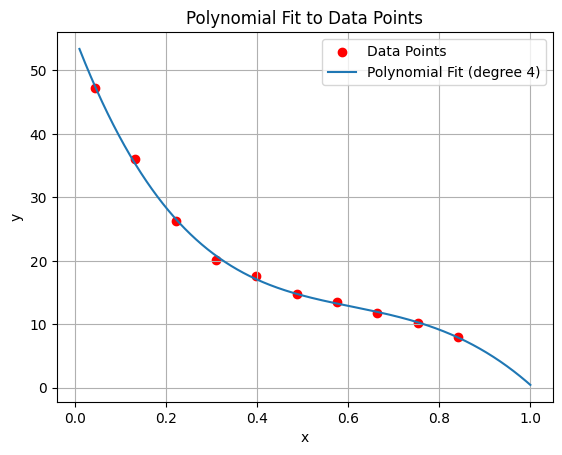

array([  38.09808137, -218.26207241,  313.9598463 , -188.5846453 ,
         55.23718825])

In [119]:

# Fit a polynomial of degree 3 (cubic) to the data
coefficients = np.polyfit(r, twirl, 4)
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial
x_fit = np.linspace(1000, 100000, 1000000) /100000
y_fit = polynomial(x_fit)

# Plot the data points and the polynomial fit
plt.scatter(r, twirl, color='red', label='Data Points')
plt.plot(x_fit, y_fit, label='Polynomial Fit (degree 4)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Fit to Data Points')
plt.legend()
plt.grid(True)
plt.show()

coefficients


# Tabu Search

In [120]:
# -------------------- User Input --------------------------------
aerofoil = aerofoil_name
wind_speeds =  np.array([1.5])#np.linspace(15,150,10)/100
objective_ = 'ratio_area'
n = 5 + elements  # Dimensions
increment0 = 1  # Step size of search
sigma0_ = np.array([0.05, 0.5, 0.3, 1, 2]) # c0, tsr, a1, a2, a3, 
sigma1_ = np.array([1.0]* elements) # Initial alpha
increment_direction = np.hstack([sigma0_, sigma1_])
beta = 0.75  # SSR factor
si = 20  # search intensification initiated
sd = 30 # 30  # search diversification initiated
ssr = 40 # step size reduction initiated
delta0 = increment0
min_increment = 1e-6
max_revisits = 10
penalty = 1
M = 4  # length MTM
T = 10  # length tabu list
D = 20  # number of random vectors generated

def f_A(x, wind_speeds, aerofoil, objective_):
    global penalty
    return objective_wind_speeds(x, wind_speeds, aerofoil, objective=objective_) + penalty * constraint_function(x)

# ------------------------------

def feasiblepoint(n):
    '''
    Determines a feasible point in n dimensions
    '''
    global countfevals

    while True:
        point = np.random.rand(n) * 10

        if constraint_function(point) == 0:
            countfevals += 1
            break
    return point

def check_distance(candidate, list, delta):
    """
    Checks that a candidate point is at least delta far away from all points in list

    returns True if it is and False if it isn't
    """
    result = all(np.linalg.norm(p[1] - candidate) > delta for p in list)
    return result

def random_unit_vector(n):
    """
    Generates a random unit vector in n dimensions.

    :param n: Dimension of the space.
    :return: A unit vector of length 1 in n-dimensional space.
    """
    # Generate a random vector with each component drawn from a normal distribution
    vector = np.random.randn(n)
    # Normalize the vector to make it a unit vector
    unit_vector = vector / np.linalg.norm(vector)
    return unit_vector

def localsearch(base_point, base_value, n, tabu):
    '''
    Search the neighborhood of the point and return the best point that is not tabu

    :param base_point: Base point to perform neighborhood search around.
    :param base_value: Objective function value of the base point
    '''
    global countfevals
    global increment
    global increment_direction

    neighborhood = []
    neighborhood_values = []
    orientation = [1, -1]
    for i in range(n):  # search axis
        for k in orientation:  # Orientation of axis
            increment_vector = np.zeros(n)
            increment_vector[i] = increment * k * increment_direction[i]
            search_point = base_point + increment_vector  # Search point axis[i] and orientation[k]

            if search_point not in tabu:  # Check if the move is allowed or tabu  
                neighborhood.append(search_point)
                neighborhood_values.append(f_A(search_point,wind_speeds, aerofoil, objective_))
                countfevals += 1  

    if neighborhood:  # Check if neighborhood is not empty
        new_point, new_value = neighborhood[np.argmin(neighborhood_values)], np.min(neighborhood_values)  # Best allowed move
               
        if new_value < base_value:  # Check if the objective was reduced by move
            c = 0
            pattern_move = base_point + (new_point - base_point)  # Compute pattern move if true
            pattern_move_value = f_A(pattern_move, wind_speeds, aerofoil, objective_)
            countfevals += 1
            if pattern_move_value < new_value:  # Check if pattern move reduced objective
                new_point, new_value = pattern_move, pattern_move_value  # assign new point 
        else: 
            c = 1
        
        return new_point, new_value, c
    else:        
        return None

# Memory
archive= am.Archive(size=25, D_min=0.3, D_sim=0.1)
sections = ts_classes.Sections()
tabu = ts_classes.TabuList(T)
ltm = ts_classes.LongTermMemory()
mtm = am.Archive(size=M, D_min=0.3, D_sim=0.1)
localminima = ts_classes.LocalMinima()

# Counter and lists
entry_count = 0
counter_best_locations = 0
counter_SI = 0
counter_SD = 0
counter_SSR = 0
countbreakout = 0
counter = 0
countfevals = 0
breakout_it_counter = 0
random_points_chosen = []
counter_empty_neighborhood = 0
local_minima = []
local_minima_rule = 0
intensification_list = [(5, 5)] 

best_locations = []
breakout_list = []

increment = increment0
maxfevals = 1000
iteration = 0

# -------------------- Initiate Search --------------------------------
# Generate starting point
starting_point = generate_random_x(aerofoil_name, wind_speeds=wind_speed)
point = starting_point.copy()
value = f_A(point,wind_speeds, aerofoil, objective_)
print('start', starting_point, value)
best_point = starting_point 
best_value = value
tabu.add(point)
mtm.add(point, value)

while countfevals <= maxfevals - 2 * n and iteration <1000:
    iteration += 1
    print('------------------------------------')
    print('iteration', iteration)
    # Test convergence
    if increment < min_increment:  # Terminates if the step size gets too small
        print('Step size too small, stopping search')
        break

    # LOCAL SEARCH: Search the points in the neighborhood
    local_search = localsearch(point, value, n, tabu)  # returns the new base point or none
    if local_search is not None:
        point, value, lm_rule = local_search  # new base point

        # Update memory
        localminima.conadd(point, lm_rule)
        mtm.add(point, value)  # Check that the point is far enough from the other points in the mtm to prevent singularity
        sections.conadd(point, delta0)  # Add to sections if at least delta0 away from all the points
        ltm.add(tuple(point))  # Update the long term memory
        tabu.add(point)  # Update the tabu list

        if localminima.found(lm_rule):  # reset counter if local minima was found
            counter = 0

    else:
        point = generate_random_x(aerofoil=aerofoil, wind_speeds=wind_speeds, objective=objective_)  # No move was allowed, search is moved to random feasible point
        value = objective_wind_speeds(point, wind_speeds, aerofoil, objective=objective_)
        countfevals += 1
    #print(point, value)
    print(value)
    if value >= best_value:  # Check and update the best solution if the new solution is better
        counter += 1  # Local search didn't find a new minima, increment counter

        if counter == si:  # INTENSIFY: Move current search location to "average best" position
            print('SI', counter_SI)
            counter_SI += 1
            w = np.random.rand(mtm.coordinates().shape[0] )  # Random weights
            w = w / np.sum(w)  # sum has to be one
            x_k = w @ mtm.coordinates()  # random point within the space spanned by the mtm
            point = x_k
            value = f_A(point,wind_speeds, aerofoil, objective_)
            print('intensify point', point, 'value', value)
            tabu.add(point)  # Update the tabu list
            ltm.add(tuple(point))  # Update the long term memory
            intensification_list.append(point)

        elif counter == sd:  # DIVERSIFICATION: Move current search location to unexplored region 
            print('SD', counter_SD)
            counter_SD += 1
            point = generate_random_x(aerofoil=aerofoil, wind_speeds=wind_speeds, objective=objective_) 
            value = objective_wind_speeds(point, wind_speeds, aerofoil, objective_)
            countfevals += 1

        elif counter == ssr:  # STEP SIZE REDUCTION
            print('SSR', counter_SSR)
            counter_SSR += 1
            increment *= beta  # Reduce search increment 
            #print('INCREMENT', increment)
            point, value = best_point, best_value  # Assign new base point
            penalty = np.exp(1 + counter_SSR)  # update penalty
            counter = 0  

    else:  # Assign new best value and continue search
        best_point, best_value = point, value
        #print('best_value', best_value)
        best_locations.append(best_point)
        counter_best_locations += 1
        counter = 0  # Set counter to zero and continue local search
    
    # -------------------- Archive --------------------------------
    candidate = (point, value)  # Coordinates and value of archive candidate
    archive.add(point, value)
print(best_point, best_value)
final_solution = (best_point, best_value)

counter 1
start [0.21418887 2.16882771 0.53956015 1.         1.         4.20758758
 4.20758758 4.20758758 4.20758758 4.20758758 4.20758758 4.20758758
 4.20758758 4.20758758 4.20758758] -3.9211882696542113
------------------------------------
iteration 1
-7.134594424367426
------------------------------------
iteration 2
-7.282795057705303
------------------------------------
iteration 3
-7.412482247425495
------------------------------------
iteration 4
-7.506669773750014
------------------------------------
iteration 5
-7.596283057837972
------------------------------------
iteration 6
-7.669482290925884
------------------------------------
iteration 7
-9.933051895874058
------------------------------------
iteration 8
-10.026833267665499
------------------------------------
iteration 9
-10.102370748963278
------------------------------------
iteration 10
-10.161518455119174
------------------------------------
iteration 11
-10.204615785864252
------------------------------------
iter

## TS Debugging

In [121]:
solution_debug = best_point.copy()
final_angle = solution_debug[1] - solution_debug[2]
rhub = starting_radius
dr = (swept_radius-rhub) / elements
c0 = solution_debug[0]
a1 = solution_debug[2]
a2 = solution_debug[3]
a3 = solution_debug[4]
l_blade = 0.95
r = np.array([dr/2 + dr*i for i in range(10)]) # distance of blade element from center
c = c0 * (1 - ((1 - a1) * r / l_blade + (1 - a2) * (r/l_blade)**2 + (1 - a3) * (r/l_blade)**3))
print('c', c)
#objective_wind_speeds_debug(solution_debug, wind_speeds, aerofoils[2])
print('twirl', BEM(solution_debug, aerofoil)[-1])
objective_function_debug(solution_debug, aerofoil, u0=1.5)

c [0.15840641 0.14763792 0.13925876 0.1348618  0.13603994 0.14438605
 0.16149302 0.18895373 0.22836107 0.28130791]
twirl [60.33561336 51.27904588 42.6726117  35.68760926 29.96039813 25.06989137
 20.81979243 17.02847284 10.192103    9.20466623]


ValueError: too many values to unpack (expected 6)

In [ ]:
for wind in wind_speeds:
    print('---------------------------------------------')   
    print('Wind speed:', wind)
    print('cp:', coefficent(solution_debug, aerofoil, wind))

---------------------------------------------
Wind speed: 1.5
cp: -2.5204526871845254


In [ ]:
# Plot the chord length distribution
plt.figure(figsize=(10, 6))
plt.plot(r, twirl, label='Chord Length Distribution')
plt.xlabel('Distance along the blade (m)')
plt.ylabel('Chord Length (m)')
plt.title('Chord Length Distribution along the Blade')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
x = np.array([ 0.29396262,  3.2388867 ,  2.90898584, -0.46797868,  0.23800509, 5.43445991,  5.24406697,  5.36529937,  4.82846504,  3.85999925, 3.38294563,  2.91263251,  2.87959883,  3.25568353,  4.37063765])
theta = BEM(x, aerofoil=aerofoil_name)[-1]
TSR = 7.77344298 
tsrrange = np.linspace(TSR*0.1, 1.5*TSR, 20)
for tsr_ in tsrrange:
    x[1] = tsr_
    print(objective_function_debug_manual(x, aerofoil, theta, u0=1.5))

Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
Not converged
Solution is None
inf
1.9016289065193036e-06
Not converged
Solution is None
inf
Not converged
Solution is None
inf
